In [34]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
import keras.backend as K

In [35]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, shape, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.shape = shape
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #
        self.v_total_loss_tracker = keras.metrics.Mean(name="v_total_loss")
        self.v_reconstruction_loss_tracker = keras.metrics.Mean(
            name="v_reconstruction_loss")
        self.v_kl_loss_tracker = keras.metrics.Mean(name="v_kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
       
    def call(self, inputs):
        _, input_label, conditional_input = self.conditional_input(inputs)
        z_mean, z_log_var = self.encoder(conditional_input)
        z_cond = self.sampling(z_mean, z_log_var, input_label)
        return self.decoder(z_cond)
    
    def conditional_input(self, inputs, label_size=10): 
  
        image_size = [self.shape[0], self.shape[1], self.shape[2]]
    
        input_img = layers.InputLayer(input_shape=image_size,
                                      dtype ='float32')(inputs[0])
        input_label = layers.InputLayer(input_shape=(label_size, ),
                                        dtype ='float32')(inputs[1])

        labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
        labels = tf.cast(labels, dtype='float32')
        ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) 
        labels = ones * labels
        conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
        return  input_img, input_label, conditional_input

    def sampling(self, z_mean, z_log_var, input_label):

        eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32,
                               mean=0., stddev=1.0, name='epsilon')
        z = z_mean + tf.exp(z_log_var / 2) * eps
        z_cond = tf.concat([z, input_label], axis=1)
        return z_cond

    def train_step(self, data):

        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
        
            input_img, input_label, conditional_input = self.conditional_input(data)
            z_mean, z_log_var = self.encoder(conditional_input)
            z_cond = self.sampling(z_mean, z_log_var, input_label)
            reconstruction = self.decoder(z_cond)
            reconstruction_loss = np.prod(self.shape) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img),
                                    tf.keras.backend.flatten(reconstruction))            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean)
                      - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            total_loss = reconstruction_loss + (self.beta * kl_loss)
            total_loss = tf.reduce_mean(total_loss) 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        input_img, input_label, conditional_input = self.conditional_input(data)
        z_mean, z_log_var = self.encoder(conditional_input)
        z_cond = self.sampling(z_mean, z_log_var, input_label)
        reconstruction = self.decoder(z_cond)
        reconstruction_loss = np.prod(self.shape) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img), tf.keras.backend.flatten(reconstruction)) # over weighted MSE    

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean)
                  - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        total_loss = reconstruction_loss + (self.beta * kl_loss)
        total_loss = tf.reduce_mean(total_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return{
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss
        }


In [36]:

cvae_encoder = load_model('models/cvae_encoder_toy.h5')
cvae_decoder = load_model('models/cvae_decoder_toy.h5')
cvae = CVAE(encoder=cvae_encoder, decoder=cvae_decoder, beta = 1)
cvae(np.zeros((1,50,50,3)))
cvae.load_weights('weights/vae.h5')

In [37]:
vae.compile(optimizer='Adam')
vae.load_weights('weights/vae.h5')
model = vae_encoder

In [38]:
import cv2

test = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)

In [39]:
test = test / 255
test.shape

(50, 50, 3)

In [40]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 50, 50, 3)


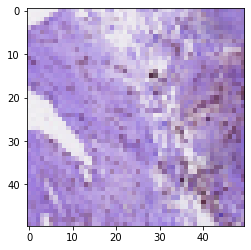

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [42]:
model.layers

In [43]:
from keras import models

# Extracts the outputs of the top 8 layers:
import tensorflow as tf

layer_outputs = []
layer_names = []
for layer in model.layers[1:]:
    
    try: 
        layer_outputs.append(layer.get_output_at(1))
        layer_names.append(layer.name)
    
    except:
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model

In [44]:
layer_names

['block1_conv1',
 'block1_conv2',
 'batch_normalization_6',
 'block2_conv1',
 'block2_conv2',
 'S2',
 'batch_normalization_7',
 'block3_conv1',
 'block3_conv2',
 'batch_normalization_8',
 'conv2d_2',
 'flatten_2',
 'z_mean',
 'z_log_var',
 'z']

In [45]:
#model.get_layer('dense_6')

In [46]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
if 'encoder' in model.name:
    activations = activation_model.predict(img_tensor) #for encoder

if 'decoder' in model.name:
    activations = activation_model.predict(vae_encoder(img_tensor)[0]) #for decoder

len(activations)

15

In [47]:
print(len(activations))
print(len(layer_names))

15
15


In [48]:
first_layer_activation = activations[9]
print(first_layer_activation.shape)
first_layer_activation.shape

(1, 25, 25, 16)


(1, 25, 25, 16)

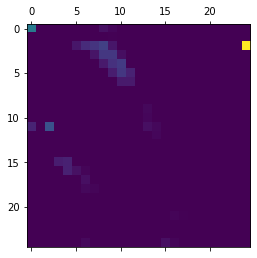

In [49]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

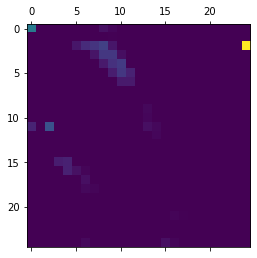

In [50]:
plt.matshow(first_layer_activation[0,:, :, 1], cmap='viridis')
plt.show()

In [51]:
activ = first_layer_activation[0,:, :, 1]

In [52]:
import math
def plot_filters(activation_layer, layer_name, counter):
    if len(activation_layer.shape) == 2: # if flat layer
        if activation_layer.shape[1] == 1875:
            activation_layer = activation_layer.reshape(1, 25, 25, 3)
        if activation_layer.shape[1] == 1024:
           activation_layer = activation_layer.reshape(1, 16, 16, 4)
        if activation_layer.shape[1] == 512:
           activation_layer = activation_layer.reshape(1, 8, 8, 8)

    n = math.floor(np.sqrt(activation_layer.shape[3]))

    if int(n + 0.5) ** 2 == activation_layer.shape[3]:

        m = n
    else:
        m = math.floor(activation_layer.shape[3] / n)

    
    if n == 1:
        fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(15, 15))
        fig.suptitle(layer_name)
        for i in range(3):
            ax[i].imshow(activation_layer[0,:, :, i], cmap='viridis')
        fig.savefig('img/activations/vae/{}_{}_activations_{}.png'.format(model.name, counter, layer_name))
        return None   

    fig, ax = plt.subplots(n, m, sharex='col', sharey='row',figsize=(15, 15))
    fig.suptitle(layer_name)
    
 

    filter_counter = 0
    for i in range(n):
        for j in range(m):
            ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
            filter_counter += 1
            if filter_counter == (activation_layer.shape[3] ):
                break
    
    fig.savefig('img/activations/vae/{}_{}_activations_{}.png'.format(model.name, counter, layer_name))
    return None

In [53]:
for activation, name in zip(activations[0:], layer_names[0:]):
    print(name)
    print(activation.shape)
    

block1_conv1
(1, 50, 50, 64)
block1_conv2
(1, 50, 50, 64)
batch_normalization_6
(1, 50, 50, 64)
block2_conv1
(1, 50, 50, 32)
block2_conv2
(1, 50, 50, 32)
S2
(1, 25, 25, 32)
batch_normalization_7
(1, 25, 25, 32)
block3_conv1
(1, 25, 25, 16)
block3_conv2
(1, 25, 25, 16)
batch_normalization_8
(1, 25, 25, 16)
conv2d_2
(1, 25, 25, 3)
flatten_2
(1, 1875)
z_mean
(1, 1000)
z_log_var
(1, 1000)
z
(1, 1000)


block1_conv1
block1_conv2
batch_normalization_6
block2_conv1
block2_conv2
S2
batch_normalization_7
block3_conv1
block3_conv2
batch_normalization_8
conv2d_2
flatten_2
z_mean


IndexError: tuple index out of range

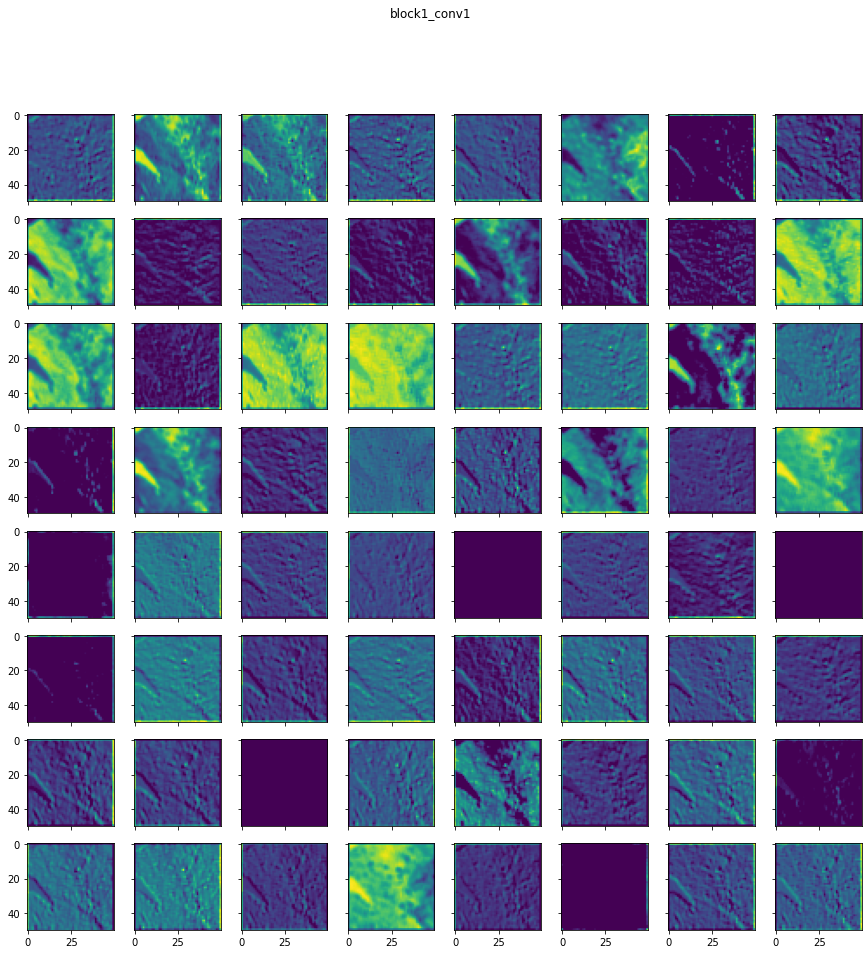

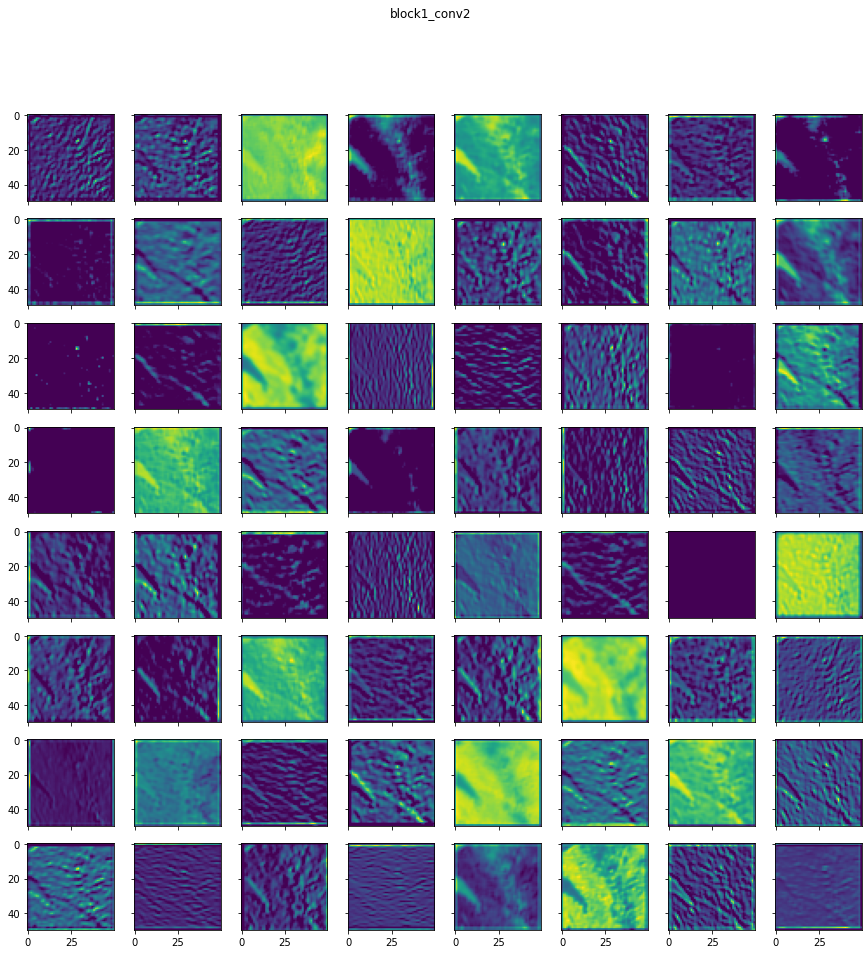

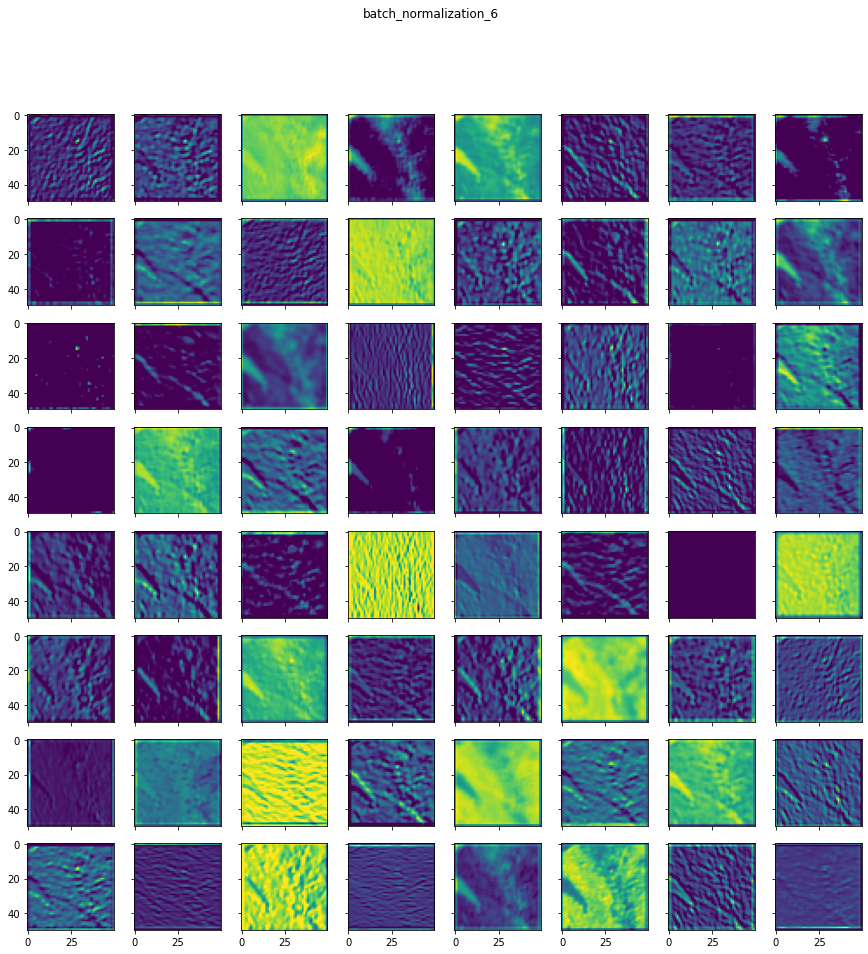

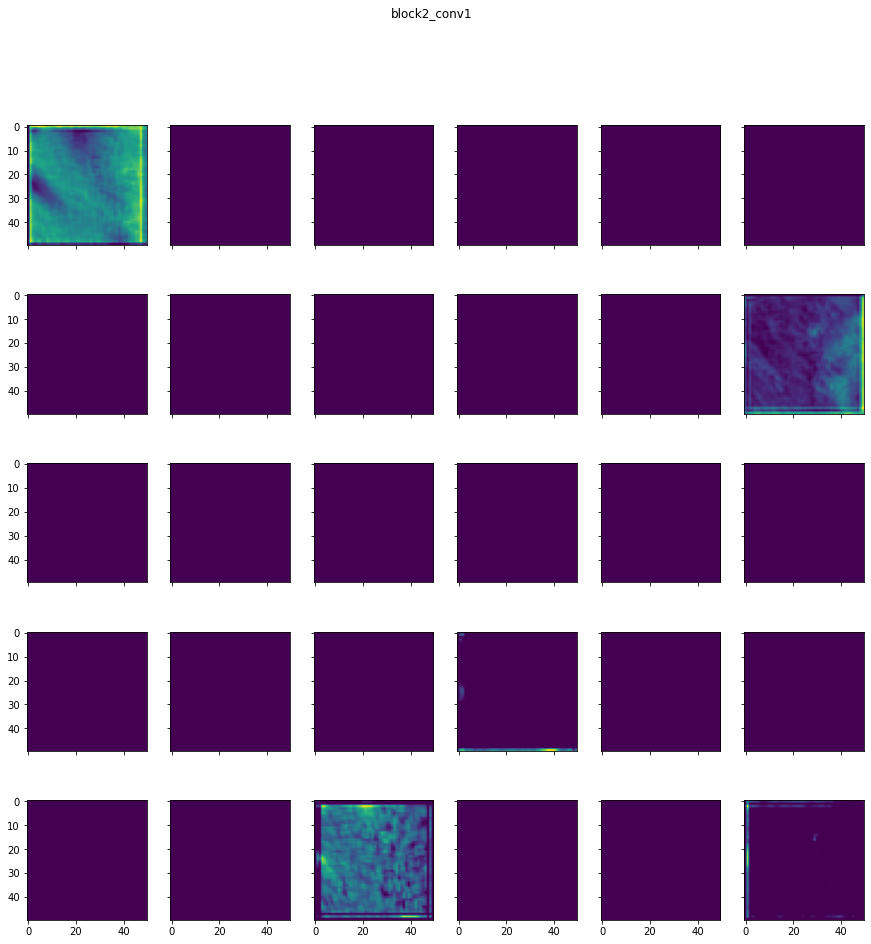

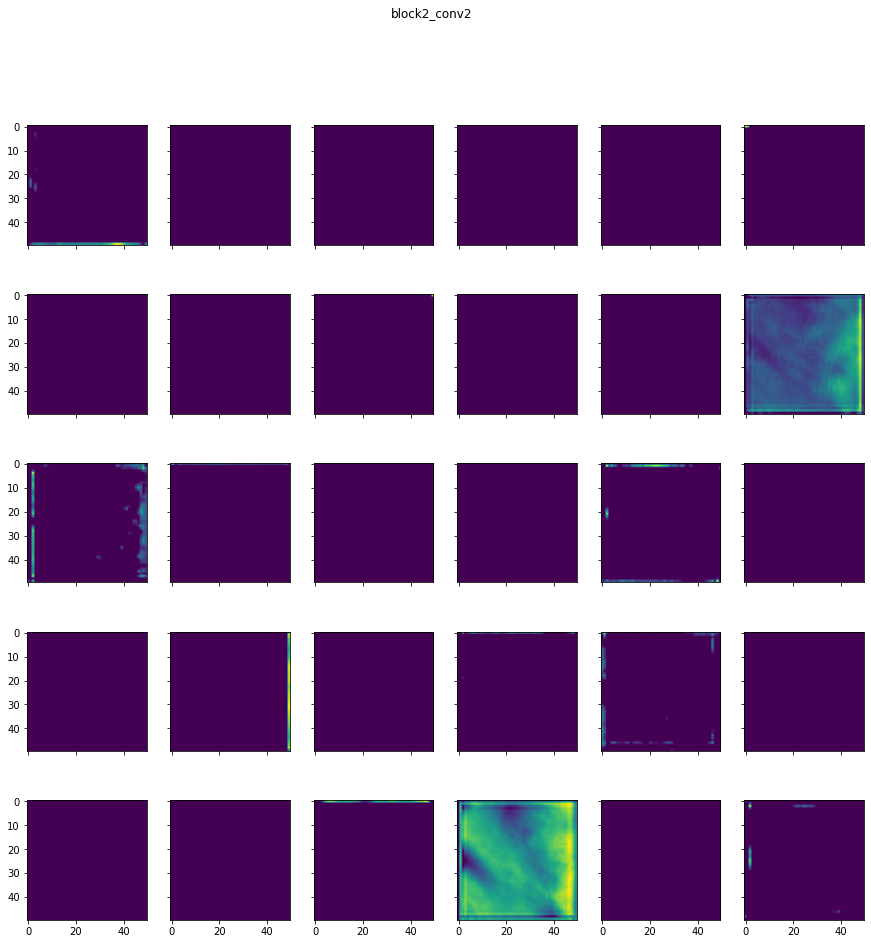

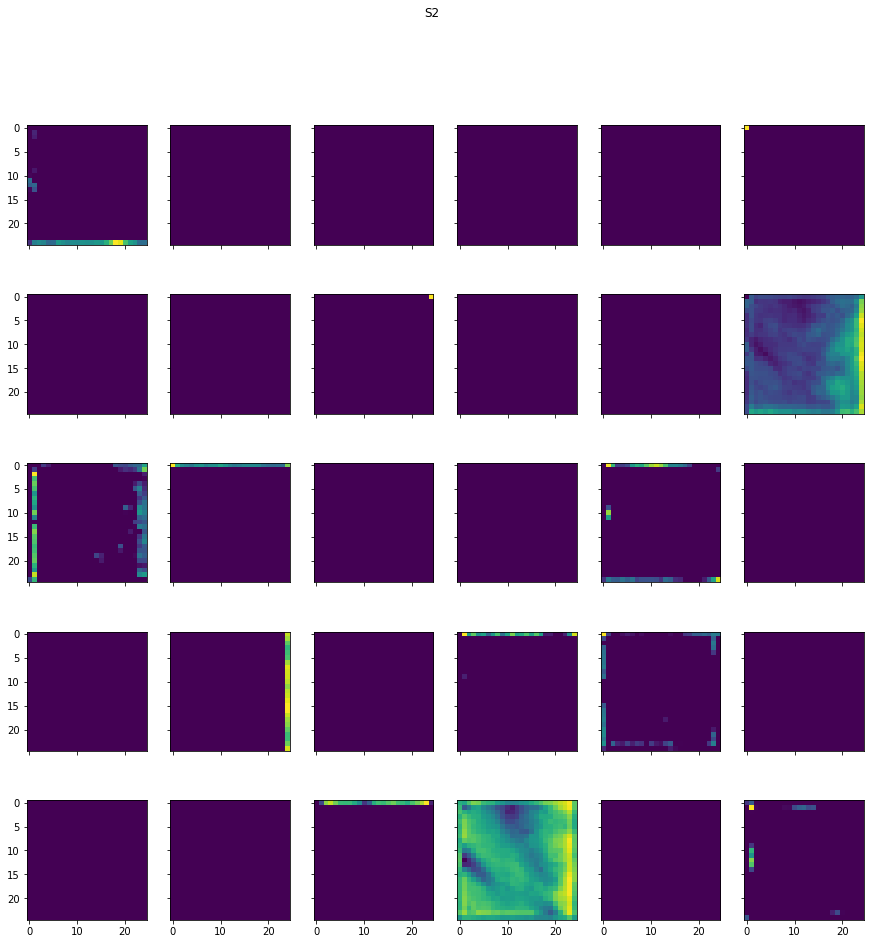

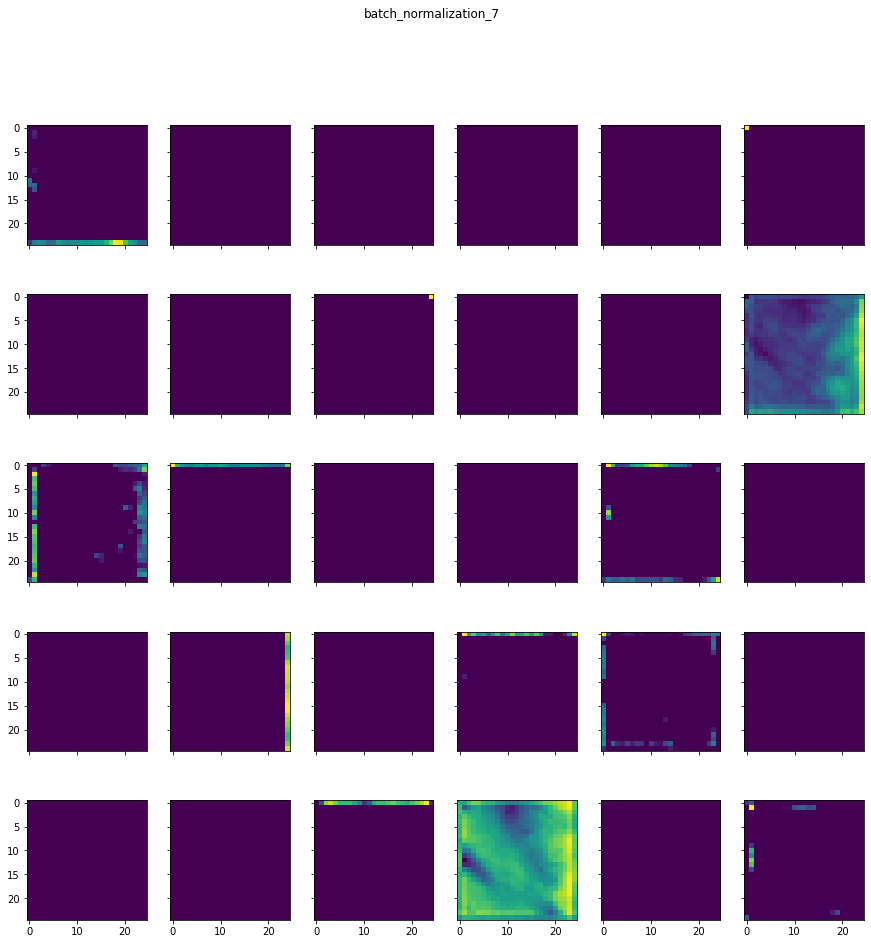

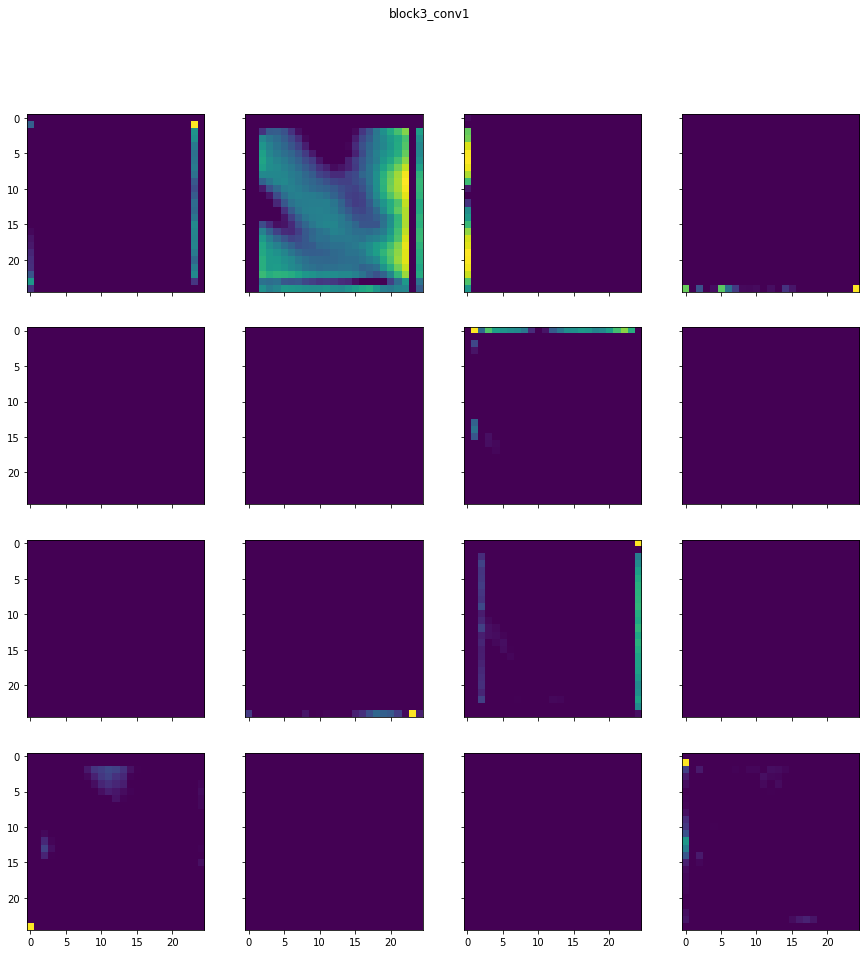

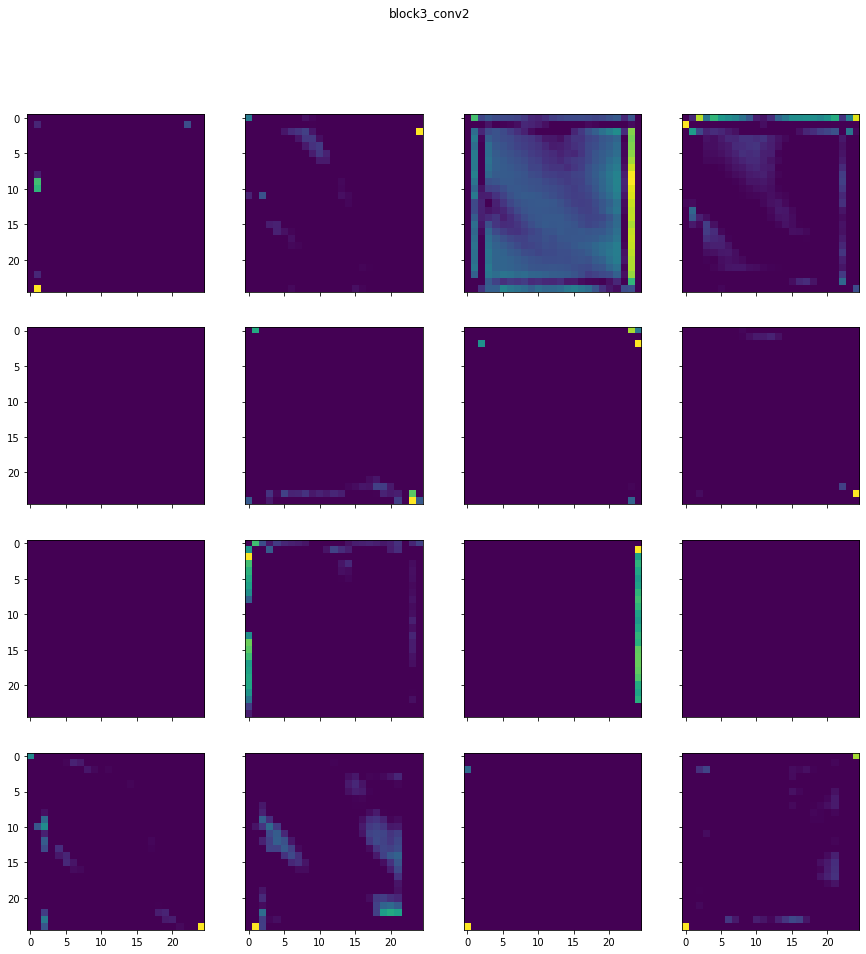

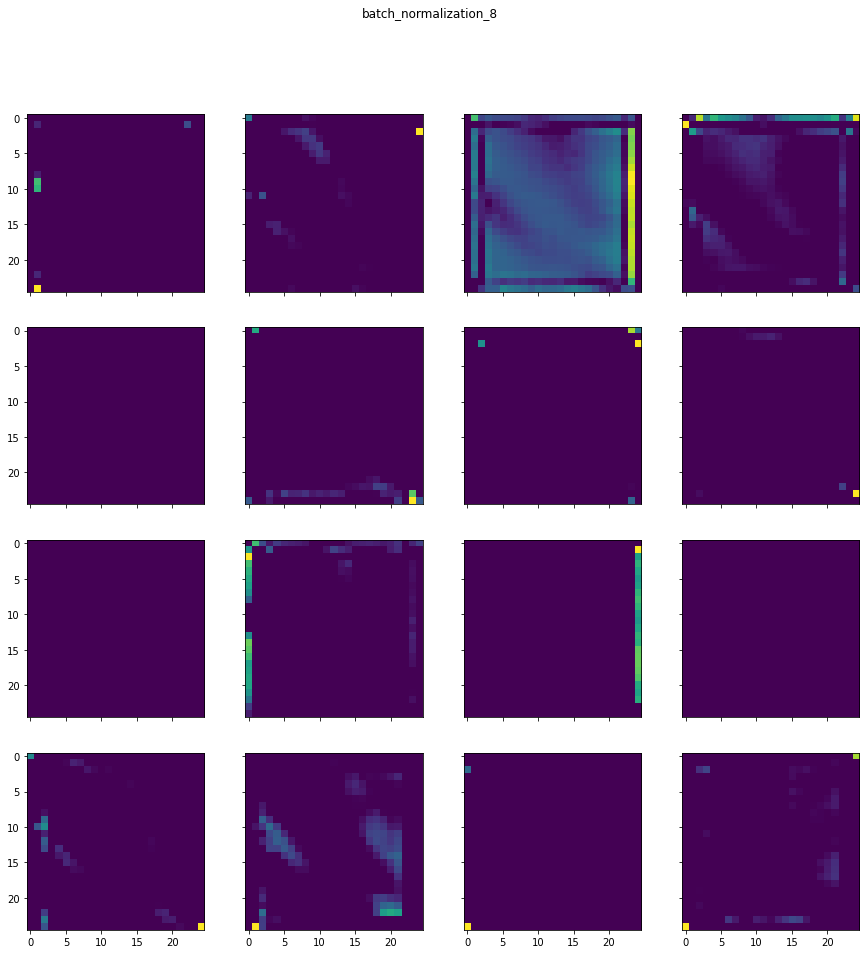

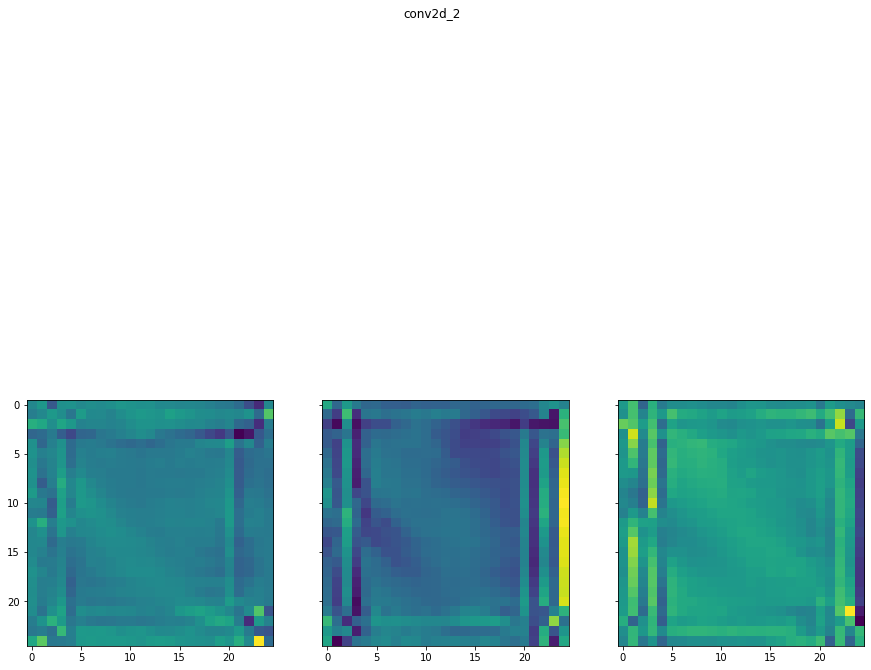

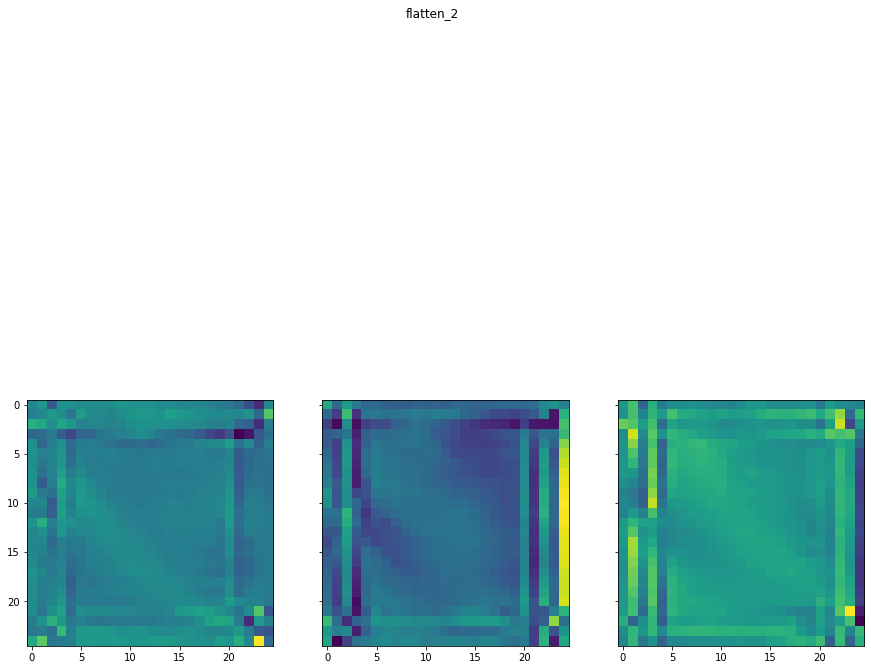

In [54]:
for counter, (activation, name) in enumerate(zip(activations[0:], layer_names[0:])):
    print(name)
    plot_filters(activation, name, counter)
    

In [ ]:
def visualize_activations_vae(test_img_link = 'datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png'):
    import cv2

    img = cv2.imread(test_img_link, cv2.IMREAD_COLOR)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    #   Remember that the model was trained on inputs
    # that were preprocessed in the following way:
    img_tensor /= 255.

    return None
    